# AML Exam (Skin disease image classification)

# 1. Importing Libraries / Defining Global Functions

In [1]:
import random # Generating Random Numbers
import os # Loading images
import shutil # Copying and moving images
import numpy as np # Handling big data
import cv2 # Image loading and augmenting
from matplotlib import pyplot as plt # Visualizing Data
import pickle # Saving/loading models
from sklearn.utils import shuffle as ashuffle
import math # For mathematical operations

# Remove unneccesary warning messages
import warnings
warnings.filterwarnings("ignore")

# Gathering model results
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# .DS_Store and .ipynb_checkpoints was generated automatically
# throughout this project, and this would mess up our loops when
# loading images, this function makes sure the loaded list deletes
# theese files to prevent problems.
def remove_unwanted_folders(folder):
    if ".DS_Store" in folder:
        folder.remove(".DS_Store")
    if ".ipynb_checkpoints" in folder:
        folder.remove(".ipynb_checkpoints")
        
# Function to predict, mainly using the KNN and the SVM
def predict_image(predict_image_path,model):
    print(f"--- Model: {model} ---\n")
    # Load new image to predict and get label from path
    image_path = predict_image_path
    actual_class = image_path.split("/")[-2]

    predict_image = cv2.imread(image_path)

    if train_x.shape[1] > 1500:
        predict_image = cv2.resize(predict_image, (224,224))
        pred = cv2.resize(predict_image, (224,224))
        pred = np.array(pred.flatten()).reshape(1,-1)/255

        # Plot actual image and the summed axis plot
        RGB_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        fig, ax = plt.subplots(ncols=1, figsize=(8,3))
        ax.imshow(RGB_image)

        # Get prediction
        prediction = model.predict(pred.reshape(1,-1))

    else:
        # If the images is only the sum of one axis:
        if train_x.shape[1] == 672:
            # Load new image to predict
            predict_image = cv2.resize(predict_image, (224,224))
            predict_image = ((np.sum(predict_image, axis=0)/224)/255).flatten()
            prediction = np.expand_dims(predict_image,axis=0)

            # Plot image in RGB
            RGB_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) # For display
            fig, ax = plt.subplots(ncols=2, figsize=(9,4))
            ax[0].plot(predict_image)    
            ax[1].imshow(RGB_image)

            # Get prediction
            prediction = model.predict(prediction)

        # If the image has been generated using the combine parameter to combine sum of rows and coloumns:
        else:
            # Load new image to predict
            predict_image = cv2.resize(predict_image, (224,224))
            pred_sum_rows = ((np.sum(predict_image, axis=0)/224)/255).flatten()
            pred_sum_coloumns = ((np.sum(predict_image, axis=1)/224)/255).flatten()
            predict_image = np.append(sum_rows,sum_coloumns)

            prediction = np.expand_dims(predict_image,axis=0)

            # Plot image in RGB
            RGB_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) # For display
            fig, ax = plt.subplots(ncols=2, figsize=(9,4))
            ax[0].plot(predict_image)    
            ax[1].imshow(RGB_image)

            # Get prediction
            prediction = model.predict(prediction)

    print(f"Actual Class: {actual_class}")
    print(f"Predicted Class: {prediction[0]}")

    if prediction == actual_class:
        print("\n   --- Correctly Classified ---   ")
    else:
        print("\n   --- Incorrectly Classified ---   ")

# 2. Data Processor Class

In [2]:
class DataProcessor:
    __doc__ = "Class that assists with data processing."
   
    def __init__(self, original_data_path, target_folder):
        
        # Define class variables from the original folder
        self.original_path = original_data_path
        self.classes = os.listdir(self.original_path)
        remove_unwanted_folders(self.classes)
        
        # If the target folder does not exis, create it.
        try:
            os.mkdir(target_folder) # Create target folder
        except:
            pass
        
        # Defining class variables from the target folder
        self.target_path = target_folder
        self.target_folder = os.listdir(self.target_path)
        remove_unwanted_folders(self.target_folder)
        print("Data Processor successfully created!")

    
    # Function that generates x and y from images
    def generate_xy(self, class_folder, shuffle=True, ignore_file_endings=[".txt",".gif"]):
        # Creates temporary lists to store images
        temp_x = []
        temp_y = []

        # Loops over each class label and creates a list of all images
        for class_label in self.classes:
            images = os.listdir(os.path.join(class_folder, class_label))
            remove_unwanted_folders(images)
            
            # Loops over all images in the class folder.
            for current_image in images:
                contains_ignored = False # Creates a check if the file contains ignored file_ending
                
                # Load every image in current class folder as cv2 image
                current_image_full_path = os.path.join(class_folder, class_label, current_image)
                
                # Loops over file endings and checks if any of the file endings are in the current image path
                for file_ending in ignore_file_endings:
                    if file_ending in current_image_full_path:
                        contains_ignored = True
                        break
                        
                # Checks if any of the file endings are in the current file, if so, continue and go to next image
                if contains_ignored == True:
                    continue
                
                # Loading and resizing image
                current_image = cv2.imread(current_image_full_path)
                current_image = cv2.resize(current_image,(224,224))

                # Adds current image to list, flattened.
                temp_x.append(current_image.flatten())
                temp_y.append(class_label)
                
        # Convert from list to array, len(temp_x) is the amount of images (array rows) and -1 is the total lenght of values (coloumns)
        # Theese values are divided by 255 to convert from standard RGB 0-255 into a more machine learning friendly 0-1 values.
        temp_x = np.array(temp_x).reshape(len(temp_x), -1)/255
        temp_y = np.array(temp_y)
        
        # Shuffling dataset (default)
        if shuffle == True:
            temp_x , temp_y = ashuffle(temp_x, temp_y)
            
        print(f"{len(temp_x)} images within {len(self.classes)} classes successfully loaded!")
        return temp_x, temp_y
    generate_xy.__doc__ = '''This function will generate array of X and array of Y data from chosen folder.
                              Folder has to contain all classes.
                              
                              Parameters:
                              
                              - class_folder: path to folder containing all classes.
                              
                              - Shuffle: Wheter to shuffle data before returning arrays.
                                         Defaults is True.
                                         
                              - ignore_file_endings: Specify which file-endings to ignore in the dataset,
                                                     Default is [".txt",".gif"]
                                         
                              Example:
                              train_x, train_y = generate_xy("./train/")'''
    
    # Function that creates graph data from images
    def generate_xy_by_axis(self, class_folder, shuffle=True, axis=0, combine=False, ignore_file_endings=[".txt",".gif"]):
        # Creates temporary lists to store images
        temp_x = []
        temp_y = []

        # Loops over each class label and creates a list of all images
        for class_label in self.classes:
            images = os.listdir(os.path.join(class_folder, class_label))
            remove_unwanted_folders(images)
            
            # Loop over each image in the current class folder
            for current_image in images:
                contains_ignored = False # Creates a check if the file contains ignored file_ending
                
                # Load every image in current class folder as cv2 image
                current_image_full_path = os.path.join(class_folder, class_label, current_image)
                
                # Loops over file endings and checks if any of the file endings are in the current image path
                for file_ending in ignore_file_endings:
                    if file_ending in current_image_full_path:
                        contains_ignored = True
                        break
                
                # Checks if any of the file endings are in the current file, if so, continue and go to next image
                if contains_ignored == True:
                    continue
                    
                # Reading and resizing image
                current_image = cv2.imread(current_image_full_path)
                current_image = cv2.resize(current_image,(224,224))
                
                # If the combine parameter is true, add the sum of all rows to the sum of all coloumns, giving twice as much data.
                if combine == True:
                    sum_rows = ((np.sum(current_image, axis=0)/224)/255).flatten()
                    sum_coloumns = ((np.sum(current_image, axis=1)/224)/255).flatten()
                    sum_axis = np.append(sum_rows,sum_coloumns)
                    temp_x.append(sum_axis)
                else:
                    # Adds current image to list, flattened.
                    sum_axis = ((np.sum(current_image, axis=axis)/224)/255).flatten()
                    temp_x.append(sum_axis)
                    
                #Append the labels
                temp_y.append(class_label)
                
        # Convert from list to array, len(temp_x) is the amount of images (array rows) and -1 is the total lenght of values (coloumns)
        # Theese values are divided by 255 to convert from standard RGB 0-255 into a more machine learning friendly 0-1 values.
        temp_x = np.array(temp_x).reshape(len(temp_x),-1)
        temp_y = np.array(temp_y)
        
        if shuffle == True:
            temp_x , temp_y = ashuffle(temp_x, temp_y)
            
        print(f"{len(temp_x)} images within {len(self.classes)} classes successfully loaded!")
        return temp_x, temp_y
    generate_xy_by_axis.__doc__ = '''This function will generate array of X and array of Y data from chosen folder.
                              Folder has to contain all classes. The image pixels will be summed by row or coloumn, then
                              divided by number of rows or coloumns to get the average by that axis. This can be plotted
                              on a graph to get interesting insights in the data.
                              
                              Parameters:
                              
                              - class_folder: path to folder containing all classes.
                              
                              - Shuffle: Wheter to shuffle data before returning arrays.
                                         Defaults is True.
                              
                              - axis:    Define which axis to sum, rows or coloumns. Default is 0 which will sum all rows.
                                         
                              - Combine: If combine is set to true, the sum of all coloumns will be added onto
                                         the sum of all rows, which will give twice as much data for the model to learn.
                                         
                              - ignore_file_endings: Specify which file-endings to ignore in the dataset,
                                                     Default is [".txt",".gif"]
                                         
                              Example:
                              train_x, train_y = generate_xy_by_axis("./train/")'''
    
    
    # Function to generate train, val and test folders in the target folder.
    def generate_folders(self):
        
        # Function for creating folders.
        def create_folders(target_path):
            # Define folders to generate
            folders = ["train","val","test"]
            for folder in folders:
                # Create new folders with the name of train, val, or test
                os.mkdir(os.path.join(self.target_path, folder))

                # For each folder, create new folder with each class labels (diseases)
                for class_label in self.classes:
                    os.mkdir(os.path.join(self.target_path, folder, class_label))
            print("Train, Val and test folders created!")
        
        # Reads the target folder and removes unwanted files.
        target_folder = os.listdir(self.target_path)
        remove_unwanted_folders(target_folder)
        
        # Check if the Target folder is empty or contains "temp"
        if (target_folder == ['temp']) or (target_folder == []):
            create_folders(self.target_path)
        else:
            # If the target folder is not empty
            print("Save folder not empty!")
            u_input = input("Do you wish to overwrite? (y/n)")

            # If they decide to overwrite, remove train, val, test folders
            if u_input == "y":
                for folder in target_folder:
                    # Keep temp folder if it exists.
                    if folder == "temp":
                        pass
                    else:
                        shutil.rmtree(os.path.join(self.target_path, folder))

                # Recreate folders
                create_folders(self.target_path)
            else:
                # If they do not decide to overwrite:
                print("Please delete folders and try again.")
    generate_folders.__doc__ = '''The generate_folders() function will generate train, validation and test folders.
                                  Theese folders will be populated with every class found in the original dataset.
                                  If the folder is not empty it will prompt to overwrite current train, val and test folders.
                                  The "temp" folder generated with augment_images will not be removed when overwriting.'''
            
    
    # Function that moves either the original data or augmented data into train, val and test.
    def train_val_test_split(self, original=False):
        # Variables for counting
        total_train_images = 0
        total_val_images = 0
        total_test_images = 0
        
        # Loading folder and checks if train, val and test exists.
        target_folder = os.listdir(self.target_path)
        if "train" in target_folder and "val" in target_folder and "train" in target_folder:
            for class_label in self.classes:
                
                # Get all images inside each corresponding disease folder
                if original == True:
                    images = os.listdir(os.path.join(self.original_path, class_label))
                else:
                    if "temp" not in target_folder:
                        break
                    images = os.listdir(os.path.join(self.target_path,"temp",class_label))
                
                # Load all images into an array and shuffle before transfering images into train, val and test.
                remove_unwanted_folders(images)
                images = np.array(images)
                np.random.shuffle(images) # This function might not work, due to changes in numpy. 
                                          # Comment out this to make the code work, however it will not mix images correctly how it used to.

            # Calculating Train, Validation and Test image count
                train_partition = int(len(images)*.7)
                total_train_images += train_partition
                
                validation_partition = int(len(images)*.2)
                total_val_images += validation_partition
                
                test_partition = int(len(images)*.1)
                total_test_images += test_partition

            # Empty lists to store all numbers in range into a list.
                train_partition_indexes = []
                validation_partition_indexes = []
                test_partition_indexes = []

            # Array of Train images from partition.
                for x in range(0,train_partition):
                    train_partition_indexes.append(x)
                train_image_array = np.take(images,train_partition_indexes)

            # Array of Validation images from partition.
                for x in range(train_partition, train_partition + validation_partition):
                    validation_partition_indexes.append(x)
                validation_image_array = np.take(images, validation_partition_indexes)

            # Array of Test images from partition.
                for x in range(train_partition + validation_partition , train_partition + validation_partition + test_partition):
                    test_partition_indexes.append(x)
                test_image_array = np.take(images, test_partition_indexes)


            # Moving images to their respective train, validation and test folders
                for current_image in train_image_array: # • Train Images
                    if original == True:
                        current_image_full_path = os.path.join(self.original_path, class_label, current_image)
                    else:
                        current_image_full_path = os.path.join(self.target_path,"temp",class_label, current_image)
                    shutil.copyfile(current_image_full_path, os.path.join(self.target_path,"train",class_label, current_image))

                for current_image in validation_image_array: # • Validation Images
                    if original == True:
                        current_image_full_path = os.path.join(self.original_path, class_label, current_image)
                    else:
                        current_image_full_path = os.path.join(self.target_path,"temp",class_label, current_image)
                    shutil.copyfile(current_image_full_path, os.path.join(self.target_path,"val",class_label, current_image))

                for current_image in test_image_array: # • Test Images
                    if original == True:
                        current_image_full_path = os.path.join(self.original_path, class_label, current_image)
                    else:
                        current_image_full_path = os.path.join(self.target_path,"temp",class_label, current_image)
                    shutil.copyfile(current_image_full_path, os.path.join(self.target_path,"test",class_label,current_image))
            
            # Displaying total image counts.
            print(f"{total_train_images} images moved into train.")
            print(f"{total_val_images} images moved into val.")
            print(f"{total_test_images} images moved into test.")
            
            # If user does not use original data, check if temp exists.
            if original == False:
                if "temp" not in target_folder:
                    print("temp not found in folder, please augment images with augment_images() first.")
                else:
                    shutil.rmtree(os.path.join(self.target_path, "temp"))
        else:
            print("Folder is missing train, val, and test folders, please run generate_folders() first.")
            
    train_val_test_split.__doc__ = '''The move_images function will transfer all augmented data into train, val and test
                             from temp which is generated using the augment_images() function.
                             
                             if original is set to True, it will split the original dataset into
                             train, val and test instead of augmented images.'''
        
    
    # Function for augmenting images from original data folder into the target folder (temp)
    def augment_images(self, scale_multiplier=1, brightness=[-60,90], contrast=[0.5,1.7], zoom=[20,40]):
        
        # Defining Functions used for augmentation
        def save_Augmented_Image(save_path,img):
            cv2.imwrite(save_path,img)

        # Function for generating random values within a range.
        def generate_r_value(min_value, max_value):
            if (type(min_value) == int) or (type(max_value) == int):
                rand_n = random.randint(min_value, max_value)
            if (type(min_value) == float) or (type(max_value) == float):
                rand_n = random.uniform(min_value, max_value)
            return rand_n
    
        # Specify Parameters
        brightness_min = brightness[0]
        brightness_max = brightness[1]
        contrast_min = contrast[0]
        contrast_max = contrast[1]
        zoom_min = zoom[0]
        zoom_max = zoom[1]
        
        # Create temporary folder
        if "temp" in (os.listdir(self.target_path)):
            print("temp was already in target folder, overwriting.")
            shutil.rmtree(os.path.join(self.target_path, "temp"))
        os.mkdir(os.path.join(self.target_path, "temp"))
        
        id_counter = 0
        original_counter = 0
        for class_label in self.classes: # Looping over all disease folders
            os.mkdir(os.path.join(self.target_path, "temp", class_label))
            self.target_folder = os.listdir(self.target_path)
            remove_unwanted_folders(self.target_folder)
            
            # Get all images inside of current disease folder
            images = os.listdir(os.path.join(self.original_path, class_label))
            remove_unwanted_folders(images)

            # Loading each image in folder
            for current_image in images:
                original_counter += 1 # Track amount of original images
                current_image_full_path = os.path.join(self.original_path, class_label, current_image) # Get full path of current image

                # ----- Augment Orginal ----
                id_counter +=1
                current_image_cv2 = cv2.imread(current_image_full_path)                              
                save_Augmented_Image(os.path.join(self.target_path, "temp", class_label, f"o_{id_counter}_"+current_image), current_image_cv2)
                
                # Adjust Brightness original
                for x in range(scale_multiplier):
                    id_counter +=1
                    brightness_image = cv2.convertScaleAbs(current_image_cv2, alpha=1, beta=generate_r_value(brightness_min,brightness_max))
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"o_b_{id_counter}_"+current_image),brightness_image)
                # Adjust Contrast original
                for x in range(scale_multiplier):
                    id_counter +=1
                    contrast_image = cv2.convertScaleAbs(current_image_cv2, alpha=generate_r_value(contrast_min, contrast_max), beta=0)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"o_c_{id_counter}_"+current_image),contrast_image)
                # Zoom original
                for x in range(scale_multiplier):
                    id_counter +=1
                    random_zoom = generate_r_value(zoom_min, zoom_max)
                    zoomed_image = current_image_cv2[random_zoom:-random_zoom, random_zoom:-random_zoom]
                    zoomed_image = cv2.resize(zoomed_image, (current_image_cv2.shape[1], current_image_cv2.shape[0]), interpolation=cv2.INTER_CUBIC)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label, f"z_{id_counter}_"+current_image), zoomed_image)


                # ---- FLip Horizontal ----
                # Flip Horizontal
                id_counter +=1
                horizontal_flip_image = cv2.flip(current_image_cv2,1)
                save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"hF_{id_counter}_"+current_image),horizontal_flip_image)

                # Adjust Brightness horizontal
                for x in range(scale_multiplier):
                    id_counter +=1
                    brightness_image = cv2.convertScaleAbs(horizontal_flip_image, alpha=1, beta=generate_r_value(brightness_min,brightness_max))
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"hf_b_{id_counter}_"+current_image),brightness_image)
                # Adjust Contrast horizontal
                for x in range(scale_multiplier):
                    id_counter +=1
                    contrast_image = cv2.convertScaleAbs(horizontal_flip_image, alpha=generate_r_value(contrast_min, contrast_max), beta=0)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"hf_c_{id_counter}_"+current_image),contrast_image)
                # Zoom horizontal flip
                for x in range(scale_multiplier):
                    id_counter +=1
                    random_zoom = generate_r_value(zoom_min, zoom_max)
                    zoomed_image = horizontal_flip_image[random_zoom:-random_zoom, random_zoom:-random_zoom]
                    zoomed_image = cv2.resize(zoomed_image, (horizontal_flip_image.shape[1], horizontal_flip_image.shape[0]), interpolation=cv2.INTER_CUBIC)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label, f"z_{id_counter}_"+current_image), zoomed_image)


                # ---- FLip Vertical ---
                # Flip Vertical
                id_counter +=1
                vertical_flip_image = cv2.flip(current_image_cv2,0)
                save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"vF_{id_counter}_"+current_image),vertical_flip_image)
                
                # Adjust Brightness vertical
                for x in range(scale_multiplier):
                    id_counter +=1
                    brightness_image = cv2.convertScaleAbs(vertical_flip_image, alpha=1, beta=generate_r_value(brightness_min, brightness_max))
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"vf_b_{id_counter}_"+current_image),brightness_image)
                # Adjust Contrast vertical
                for x in range(scale_multiplier):
                    id_counter +=1
                    contrast_image = cv2.convertScaleAbs(vertical_flip_image, alpha=generate_r_value(contrast_min , contrast_max), beta=0)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"vf_c_{id_counter}_"+current_image),contrast_image)
                # Zoom vertical flip
                for x in range(scale_multiplier):
                    id_counter +=1
                    random_zoom = generate_r_value(zoom_min, zoom_max)
                    zoomed_image = vertical_flip_image[random_zoom:-random_zoom, random_zoom:-random_zoom]
                    zoomed_image = cv2.resize(zoomed_image, (vertical_flip_image.shape[1], vertical_flip_image.shape[0]), interpolation=cv2.INTER_CUBIC)

        print(f"{id_counter-original_counter} augmented images created from {original_counter} original images. Total: {id_counter} images.")
        u_input = input("Do you wish to move theese into train, val, test using the train_val_test_split() function? (y/n)")
        if u_input == "y":
            self.train_val_test_split()
    augment_images.__doc__ = '''The augment_images function will generate augmented images from the original images.
    
                                 Parameters:
                                 
                                 - scale_multiplier:    how many brightness, contrast and zoom images to create from original, vertical flipped 
                                                        and horizontal flipped image. Default is 2.

                                 - brightness:  list of min and max brightness variation that will be applied to image.
                                                Default for brightness is [-60,90]

                                 - contrast:    list of min and max contrast variation that will be applied to image.
                                                Default for contrast is [0.5,1.7]

                                 - zoom:        List of min and max zoom variation that will be applied to image.
                                                Default for zoom is [0.5,1.7]'''
    
    def visualize_data(self, x, y):
        # Plotting First 4 datapoints as a sample of the dataset
        # If the shape is greater than 1500, this means they are images and not summed coloumn dataset.
        
        if train_x.shape[1] > 1500:
            plot_images = train_x.reshape((len(train_x),224,224,3))
            fig, ax = plt.subplots(ncols=4, figsize=(15,15))
            # Looping over 4 images and plotting them
            for index, image in enumerate(train_x[:4]):
                ax[index].imshow(plot_images[index])
                ax[index].title.set_text(train_y[index])

        else:
            # Plotting Sample of the dataset
            fig, ax = plt.subplots(ncols=4, figsize=(17,4))
            # Looping over 4 images and plotting them
            for index, image in enumerate(train_x[0:4]):
                ax[index].plot(train_x[index])
                ax[index].title.set_text(train_y[index])
    visualize_data.__doc__ = '''Visualize_data will display the first 4 items in the data.
    
                                 Parameters:
                                 
                                 - x:    The data
                                 - y:    The labels'''

# 3. K-Nearest Neighbor (KNN)

## • Importing Libraries

In [3]:
from sklearn.neighbors import KNeighborsClassifier

## • Load processed data

In [4]:
knn_processor = DataProcessor("./Data/original_data/","./Data/augmented_data/")

Data Processor successfully created!


In [31]:
knn_processor.generate_folders()

Train, Val and test folders created!


In [32]:
knn_processor.augment_images(scale_multiplier=1, 
                             brightness=[-60, 90], 
                             contrast=[0.5, 1.7],
                             zoom=[20, 40])

23180 augmented images created from 1159 original images. Total: 24339 images.


Do you wish to move theese into train, val, test using the move_images() function? (y/n) y


15411 images moved into train.
4402 images moved into val.
2199 images moved into test.


In [ ]:
knn_processor.train_val_test_split(original=False)

In [5]:
train_x, train_y = knn_processor.generate_xy_by_axis("./Data/augmented_data/train",axis=0,combine=False, shuffle=True)
test_x, test_y = knn_processor.generate_xy_by_axis("./Data/augmented_data/test",axis=0, combine=False, shuffle=True)

8923 images within 8 classes successfully loaded!
1272 images within 8 classes successfully loaded!


In [60]:
train_x, train_y = knn_processor.generate_xy("./Data/augmented_data/train")
test_x, test_y = knn_processor.generate_xy("./Data/augmented_data/test")

808 images within 8 classes successfully loaded!
114 images within 8 classes successfully loaded!


## • Visualizing Loaded Data

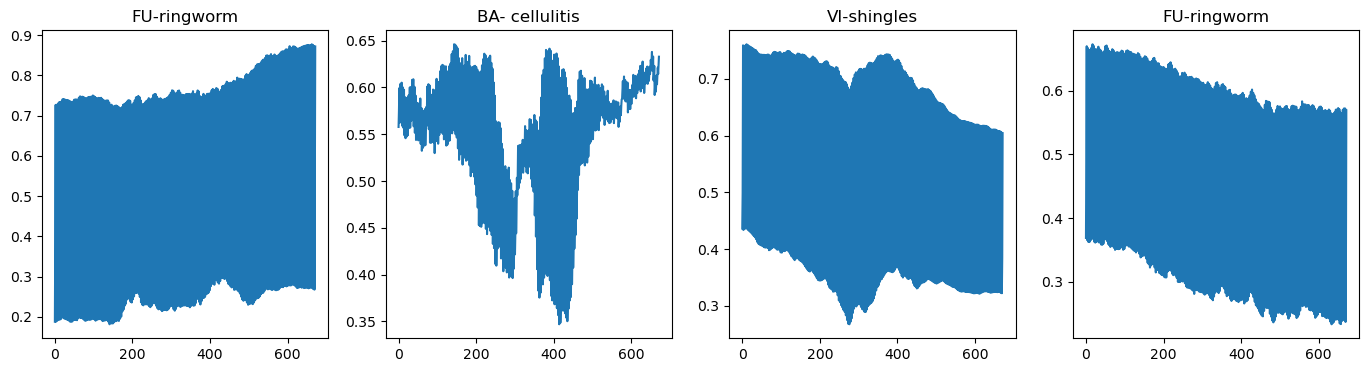

In [6]:
knn_processor.visualize_data(train_x, train_y)

## • Define Model

In [80]:
# Tuning n_neighbors
# Lower value makes model more prone to overfitting (lot more spesific to datapoint)
# Higher value makes model less prone to overfitting (more generelised, however worse predictions if value is too high)
# Default = 5
knn = KNeighborsClassifier(n_neighbors=5)

## • Train Model

In [81]:
%%time
knn.fit(train_x, train_y)

CPU times: total: 15.6 ms
Wall time: 15 ms


KNeighborsClassifier(n_neighbors=4)

## • Gathering Model Results

In [82]:
%%time
# For images:
#result_image_count = 200

# For graph images:
result_image_count = 2000

# Predict x amount of images
y_pred_train = knn.predict(train_x[:result_image_count])
y_pred_test = knn.predict(test_x[:result_image_count])

CPU times: total: 2.08 s
Wall time: 594 ms


### • Accuracy Score

In [83]:
# Calculate accuracy on training data and test data, on x amount of images
print(f"Training accuracy:  {accuracy_score(train_y[:result_image_count], y_pred_train)}")
print(f"Test accuracy:  {accuracy_score(test_y[:result_image_count], y_pred_test)}")

Training accuracy:  0.7975
Test accuracy:  0.6485849056603774


### • Classification Report

In [84]:
# Print out classification report
c_report = classification_report(test_y[:result_image_count],y_pred_test)
print(c_report)

                            precision    recall  f1-score   support

            BA- cellulitis       0.64      0.63      0.64       187
               BA-impetigo       0.69      0.57      0.63       110
           FU-athlete-foot       0.74      0.74      0.74       171
            FU-nail-fungus       0.68      0.50      0.58       178
               FU-ringworm       0.57      0.63      0.59       123
PA-cutaneous-larva-migrans       0.62      0.58      0.60       137
             VI-chickenpox       0.64      0.81      0.71       187
               VI-shingles       0.62      0.67      0.64       179

                  accuracy                           0.65      1272
                 macro avg       0.65      0.64      0.64      1272
              weighted avg       0.65      0.65      0.65      1272



## • Load model

In [5]:
# Load model using pickle
model_path = "../../Saved_Models/knn.h5"
rfc = pickle.load(open(model_path, 'rb'))

CPU times: total: 2.53 s
Wall time: 10.4 s


## • Export model as pickle

In [19]:
%%time
# Export model, using pickle. Might take a few minutes.
save_model ="../../Saved_Models/knn_61.h5"
pickle.dump(k_nn, open(save_model, 'wb'))

CPU times: total: 1min 8s
Wall time: 4min 15s


## • Predict with model

--- Model: KNeighborsClassifier(n_neighbors=4) ---

Actual Class: BA-impetigo
Predicted Class: BA-impetigo

   --- Correctly Classified ---   


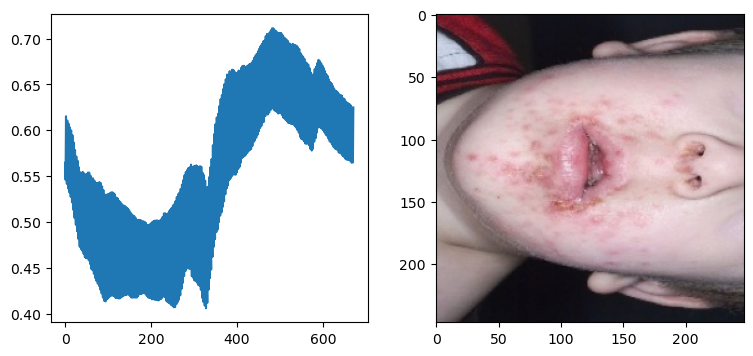

In [86]:
# Predict using the class created in section 1. of the program.
predict_image("./Data/original_data/BA-impetigo/66_BA-impetigo (1).jpg",knn)

# 4. Convolutional Neural Network (CNN)

## • Importing Tensorflow libraries for CNN model

In [126]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

## • Loading data with tensorflow

In [88]:
train = tf.keras.utils.image_dataset_from_directory("./Data/augmented_data/train/",image_size=(224,224))
val = tf.keras.utils.image_dataset_from_directory("./Data/augmented_data/val/", image_size=(224,224))

Found 8910 files belonging to 8 classes.
Found 2543 files belonging to 8 classes.


## • Transforming from regular 0-255 values to 0-1 values

In [89]:
train = train.map(lambda x,y: (x/255, y))
val = val.map(lambda x,y: (x/255, y))

## • Defining Model Structure

In [90]:
cnn = Sequential()

In [ ]:
# Define model architecture with 64 dense layer in the end
cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(8, activation='softmax'))

In [53]:
# Define model architecture with 128 dense layer in the end
cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(8, activation='softmax'))

In [54]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 54, 54, 64)       

## • Compiling and training model

In [55]:
cnn.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [56]:
%%time
# Saving stats in hist and fitting model.
hist = cnn.fit(train, epochs=5, validation_data=val)

Epoch 1/5
279/279 [==============================] - 100s 356ms/step - loss: 2.3098 - accuracy: 0.1846 - val_loss: 1.9018 - val_accuracy: 0.2969
Epoch 2/5
279/279 [==============================] - 105s 374ms/step - loss: 1.6185 - accuracy: 0.4143 - val_loss: 1.2143 - val_accuracy: 0.5985
Epoch 3/5
279/279 [==============================] - 105s 376ms/step - loss: 1.0943 - accuracy: 0.6203 - val_loss: 0.9074 - val_accuracy: 0.7236
Epoch 4/5
279/279 [==============================] - 105s 377ms/step - loss: 0.7947 - accuracy: 0.7288 - val_loss: 0.6754 - val_accuracy: 0.7967
Epoch 5/5
279/279 [==============================] - 106s 381ms/step - loss: 0.6551 - accuracy: 0.7792 - val_loss: 0.5299 - val_accuracy: 0.8521
CPU times: user 54min 32s, sys: 5min 18s, total: 59min 50s
Wall time: 8min 40s


## • Results

### • Plotting Training Statistics

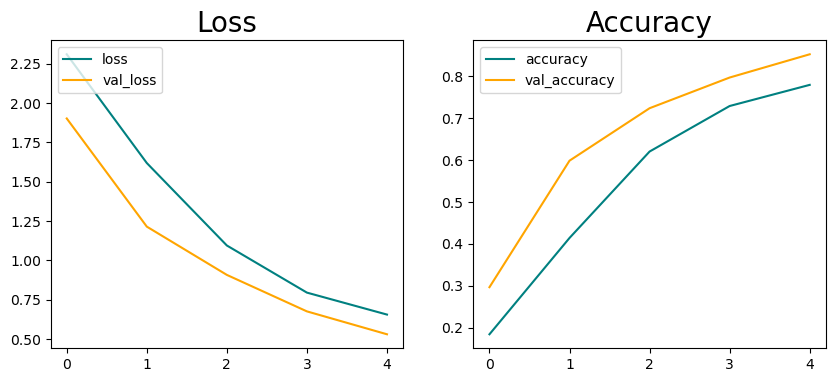

In [59]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend(loc="upper left")

ax[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
ax[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend(loc="upper left")
plt.show()

## • Load model

In [ ]:
# Model saved in Saved_Models folder in the desktop
cnn = tf.keras.models.load_model('../../Saved_Models/CNN_079.h5')

## • Export model as pickle

In [140]:
# Save model to Saved_Models folder in the desktop
cnn.save(os.path.join("../../Saved_Models","CNN_id_3.h5"))

## • Model Prediction

#### • Loading unseen image for prediction

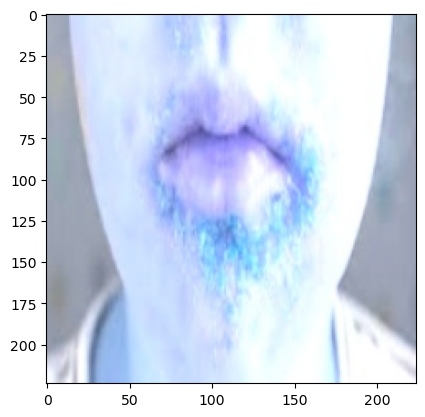

In [84]:
pred_image = cv2.imread('./Data/augmented_data/train/BA-impetigo/hf_b_8382_57_BA-impetigo (6).jpeg')
resize = cv2.resize(pred_image, (224,224))
plt.imshow(resize)

#### • Mapping Classes to indexes

In [61]:
class_map = {
    0: 'BA- cellulitis',
    1: 'BA-impetigo',
    2: 'FU-athlete-foot',
    3: 'FU-nail-fungus',
    4: 'FU-ringworm',
    5: 'PA-cutaneous-larva-migrans',
    6: 'VI-chickenpox',
    7: 'VI-shingles'}

#### • Resizing and prediction

In [85]:
# Resizing image from 0-255 to 0-1
pred_image = resize/255

# Expading dimension for it to fit the model
yhat = cnn.predict(np.expand_dims(pred_image, 0))

# Printing prediction values
print(yhat[0])

# Finding prediction with highest value
print(f"{class_map[np.argmax(yhat)]}")

1/1 [==============================] - 0s 13ms/step
[9.6731722e-01 2.6534572e-06 2.9266271e-06 3.2665957e-02 5.5118721e-06
 2.7161077e-06 1.7100127e-06 1.1710354e-06]
BA- cellulitis


The model turned out to be very overfit in certain classes, such as BA - cellulitis

# 5. Support Vector Machine (SVM)

## • Importing Libraries

In [92]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

## • Loading Data

In [88]:
# Create DataProcessor object
svc_processor = DataProcessor("./Data/original_data/","./Data/augmented_data/")

Data Processor successfully created!


In [20]:
svc_processor.generate_folders()

Save folder not empty!
Do you wish to overwrite? (y/n) y
Train, Val and test folders created!


In [21]:
# Generate Augmented images using the DataProcessor class.
svc_processor.augment_images(copies=1, 
                             brightness=[-60, 90], 
                             contrast=[0.5, 1.7],
                             zoom=[20, 40])

2318 augmented images created from 1159 original images. Total: 3477 images.
Do you wish to move theese into train, val, test using the move_images() function? (y/n) y
2432 images moved into train.
693 images moved into val.
344 images moved into test.


In [90]:
# Generating Data from sum of axis
train_x, train_y = svc_processor.generate_xy_by_axis("./Data/augmented_data/train",axis=0,combine=False, shuffle=True)
test_x, test_y = svc_processor.generate_xy_by_axis("./Data/augmented_data/test",axis=0, combine=False, shuffle=True)

8923 images within 8 classes successfully loaded!
1272 images within 8 classes successfully loaded!


In [75]:
# Generating Data from whole image
train_x ,train_y = svc_processor.generate_xy("./Data/augmented_data/train")
test_x ,test_y = svc_processor.generate_xy("./Data/augmented_data/test")

8923 images within 8 classes successfully loaded!
1273 images within 8 classes successfully loaded!


## • Visualizing Loaded Data

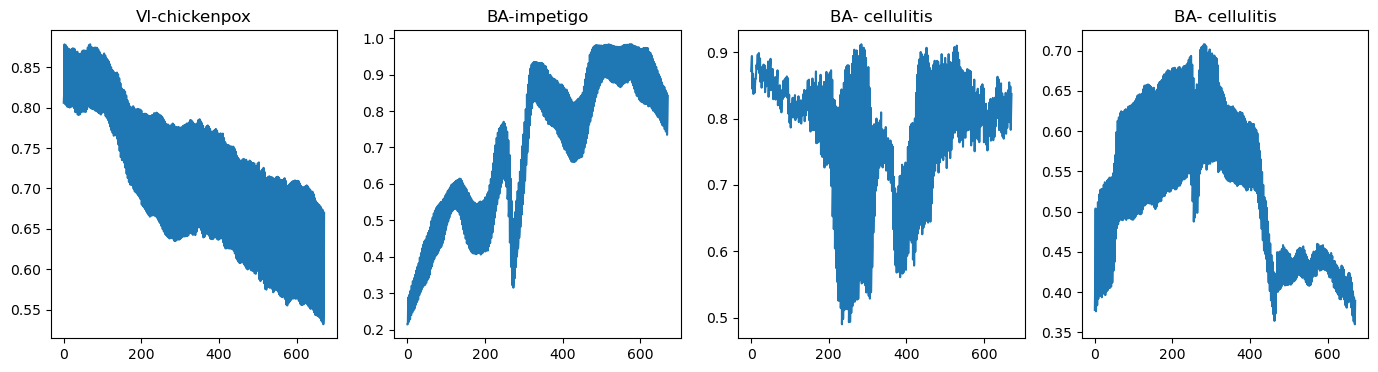

In [91]:
svc_processor.visualize_data(train_x, train_y)

## • Training Support Vector Classifier (SVC)

In [94]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}

In [96]:
# Creating a gridsearch object to find best parameters for SVC
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(train_x, train_y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  50.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  46.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  44.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  45.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  44.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  43.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  54.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 1.5min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 1.5min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 1.2min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  43.3s
[CV] END ......................C=0.1, gamma=0.01

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [97]:
# Finding best estimator resulted in:
# C=100
# gamma=0.1
print(grid.best_estimator_)

SVC(C=100, gamma=0.1)


In [98]:
%%time
# 1h 5min 10s on desktop (augmented images)
svc = SVC(kernel="rbf", C=100, gamma=0.1) # Using parameters found in the gridsearch
svc.fit(train_x,train_y)

CPU times: total: 31.3 s
Wall time: 31.5 s


SVC(C=100, gamma=0.1)

## • Gathering Model Results

In [99]:
%%time
# 48min 59s (400 images) on desktop (augmented images)
result_image_count = 400

# Use this if model is trained on graph data.
result_image_count = 2000

y_pred_train = svc.predict(train_x[:result_image_count])
y_pred_test = svc.predict(test_x[:result_image_count])

CPU times: total: 12.4 s
Wall time: 12.4 s


### • Accuracy Score

In [100]:
print(f"Training accuracy:  {accuracy_score(train_y[:result_image_count], y_pred_train)}")
print(f"Test accuracy:  {accuracy_score(test_y[:result_image_count], y_pred_test)}")

Training accuracy:  0.9935
Test accuracy:  0.7979559748427673


### • Classification Report

In [101]:
c_report = classification_report(test_y[:result_image_count],y_pred_test)
print(c_report)

                            precision    recall  f1-score   support

            BA- cellulitis       0.76      0.78      0.77       187
               BA-impetigo       0.78      0.75      0.76       110
           FU-athlete-foot       0.83      0.85      0.84       171
            FU-nail-fungus       0.75      0.74      0.74       178
               FU-ringworm       0.78      0.76      0.77       123
PA-cutaneous-larva-migrans       0.77      0.75      0.76       137
             VI-chickenpox       0.85      0.91      0.88       187
               VI-shingles       0.84      0.80      0.82       179

                  accuracy                           0.80      1272
                 macro avg       0.80      0.79      0.79      1272
              weighted avg       0.80      0.80      0.80      1272



## • Load model

In [257]:
model_path = "../../Saved_Models/SVC_77.h5"
svc = pickle.load(open(model_path, 'rb'))

## • Export model as pickle

In [81]:
%%time
# __min __s on Macbook Air m2
# __min __s on desktop
save_model ="../../Saved_Models/SVC_77.h5"
pickle.dump(svc, open(save_model, 'wb'))

CPU times: total: 3min 2s
Wall time: 4min 46s


## • Predict with model

--- Model: SVC(C=100, gamma=0.1) ---

Actual Class: BA- cellulitis
Predicted Class: BA- cellulitis

   --- Correctly Classified ---   


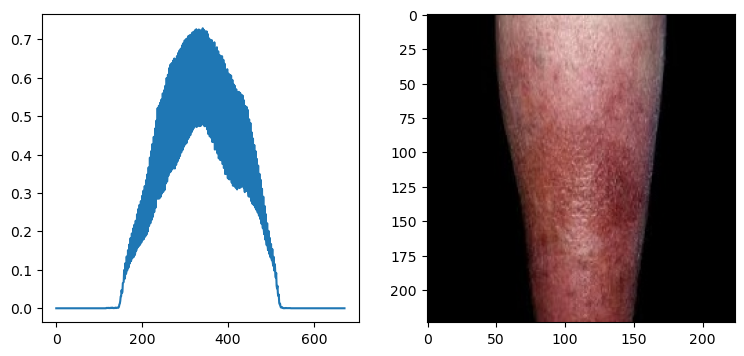

In [108]:
predict_image('./Data/original_data/BA- cellulitis/BA- cellulitis (130).jpg', svc)

# Other insights

## ORB Detection

We wanted to see if it would be possible to potensially train a model on the keypoints found inside the images, but we quickly saw that the keypoints often was around the body part and not the infection itself.

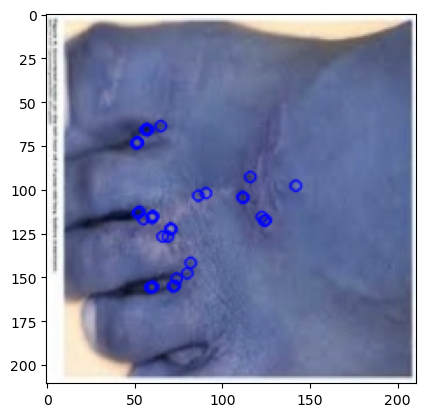

In [204]:
image = cv2.imread("./Data/original_data/PA-cutaneous-larva-migrans/33_PA-cutaneous-larva-migrans (40).jpg")
orb = cv2.ORB_create()
keypoints = orb.detect(image, None)
kp, descriptors = orb.compute(image, keypoints)

image_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0,0,255), flags=0)
plt.imshow(image_keypoints)